In [1]:
## general imports
import json
import numpy as np

## COCO imports
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval
from pycocotools.cocoanalyze import COCOanalyze

## plotting imports
%matplotlib inline
import matplotlib.pyplot as plt
import skimage.io as io

In [2]:
## set paths
dataDir  = '.'
dataType = 'testdev2015'
annType  = 'keypoints'
teamName = 'cmu' #maskrnn9 maskrnn10 cmu grmi

annFile  = '%s/annotations/%s_%s.json'%(dataDir, annType, dataType)
resFile  = '%s/detections/%s_%s_%s_results.json'%(dataDir, teamName, annType, dataType)

print("{:10}[{}]".format('annFile:',annFile))
print("{:10}[{}]".format('resFile:',resFile))

gt_data   = json.load(open(annFile,'rb'))
imgs_info = {i['id']:{'id':i['id'] ,
                      'width':i['width'],
                      'height':i['height']}
                       for i in gt_data['images']}

annFile:  [./annotations/keypoints_testdev2015.json]
resFile:  [./detections/cmu_keypoints_testdev2015_results.json]


In [3]:
team_dts = json.load(open(resFile,'rb'))
team_dts = [d for d in team_dts if d['image_id'] in imgs_info]
# max_score = np.max([d['score'] for d in team_dts])
# min_score = np.min([d['score'] for d in team_dts])
# for d in team_dts:
#     #d['score'] = d['score'] / float(max_score)
#     d['score'] = (d['score']- float(min_score)) / (float(max_score) - float(min_score))

team_dts_dict = {}
for d in team_dts:
    if d['image_id'] in team_dts_dict:
        team_dts_dict[d['image_id']].append(d)
    else:
        team_dts_dict[d['image_id']] = [d]
pruned_team_dts = []
for iid in team_dts_dict:
    pruned_team_dts.extend(sorted(team_dts_dict[iid], key=lambda k: -k['score'])[:20])
team_dts = pruned_team_dts

team_img_ids = set([d['image_id'] for d in team_dts])
print("Loaded [{}] instances in [{}] images.".format(len(team_dts),len(imgs_info)))

## load ground truth annotations
coco_gt = COCO( annFile )

## initialize COCO detections api
coco_dt   = coco_gt.loadRes( team_dts )

## initialize COCO analyze api
coco_analyze = COCOanalyze(coco_gt, coco_dt, 'keypoints')

Loaded [46256] instances in [20288] images.
loading annotations into memory...
Done (t=1.06s)
creating index...
index created!
Loading and preparing results...
DONE (t=1.06s)
creating index...
index created!


In [4]:
# use evaluate() method for standard coco evaluation
# input arguments:
#  - verbose   : verbose outputs    (default: False)
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

#coco_analyze.evaluate(verbose=True, makeplots=True)

In [5]:
## NOTE: the values below are all default

# set OKS threshold of the extended error analysis
coco_analyze.params.oksThrs       = [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]

# set OKS threshold required to match a detection to a ground truth
coco_analyze.params.oksLocThrs    = .1

# set KS threshold limits defining jitter errors
coco_analyze.params.jitterKsThrs = [.5,.85]

# set the localization errors to analyze and in what order
# note: different order will show different progressive improvement
# to study impact of single error type, study in isolation
coco_analyze.params.err_types = ['miss','swap','inversion','jitter']

# area ranges for evaluation
# 'all' range is union of medium and large
coco_analyze.params.areaRng       = [[32 ** 2, 1e5 ** 2]] #[[96 ** 2, 1e5 ** 2],[32 ** 2, 96 ** 2],[32 ** 2, 1e5 ** 2]]
coco_analyze.params.areaRngLbl    = ['all']               #['large','medium','all']

coco_analyze.params.maxDets = [20]

In [6]:
# use analyze() method for advanced error analysis 
# input arguments:
#  - check_kpts   : analyze keypoint localization errors for detections with a match (default: True)
#                 : errors types are ['jitter','inversion','swap','miss']
#  - check_scores : analyze optimal score (maximizing oks over all matches) for every detection (default: True)
#  - check_bkgd   : analyze background false positives and false negatives (default: True)

coco_analyze.analyze(check_kpts=False, check_scores=True, check_bckgd=True)

<mrr:2.0>Analyzing detection scores...
<mrr:2.0>Running per image *optimal score* evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=8.83s).
<mrr:2.0>DONE (t=12.58s).
<mrr:2.0>Analyzing background false positives and false negatives...
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.83s).
<mrr:2.0>DONE (t=12.41s).


In [7]:
#coco_analyze.evaluate(verbose=True, makeplots=True)

<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=10.00s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.10s).
<mrr:2.0>Correcting area range [all]:
<mrr:2.0>Correcting error type [score]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.34s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Correcting area range [all]:
<mrr:2.0>Correcting error type [bckgd. fp, fn]:
<mrr:2.0>Running per image evaluation...
<mrr:2.0>Evaluate annotation type *keypoints*
<mrr:2.0>DONE (t=9.33s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.76s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Accumulating evaluation results...
<mrr:2.0>DONE (t=0.09s).
<mrr:2.0>Accumul

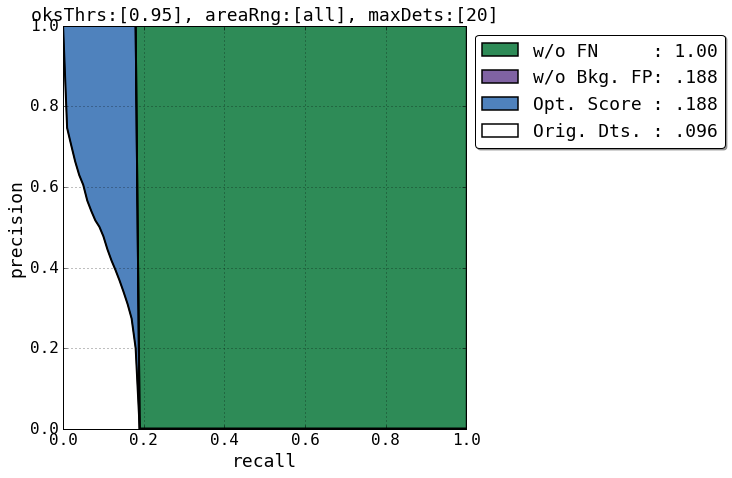

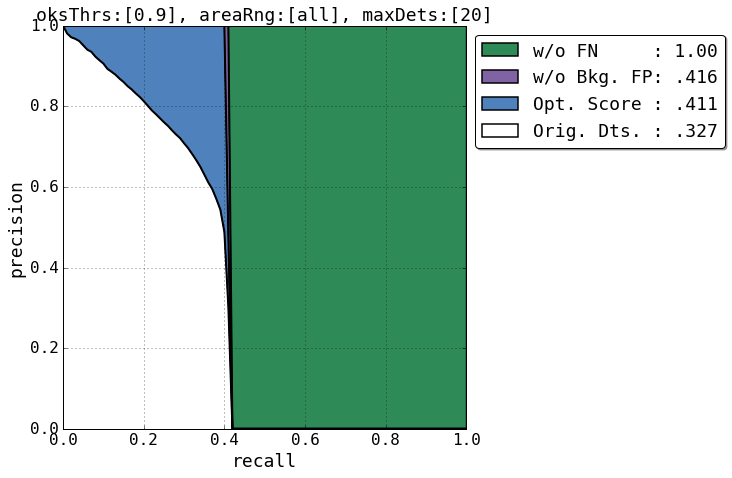

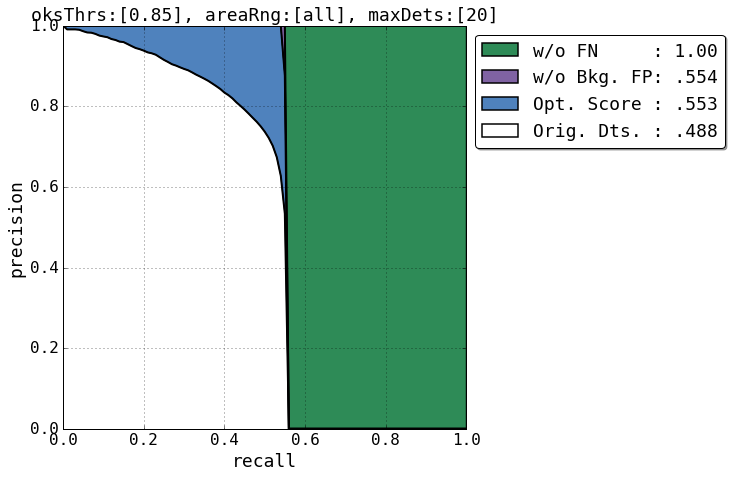

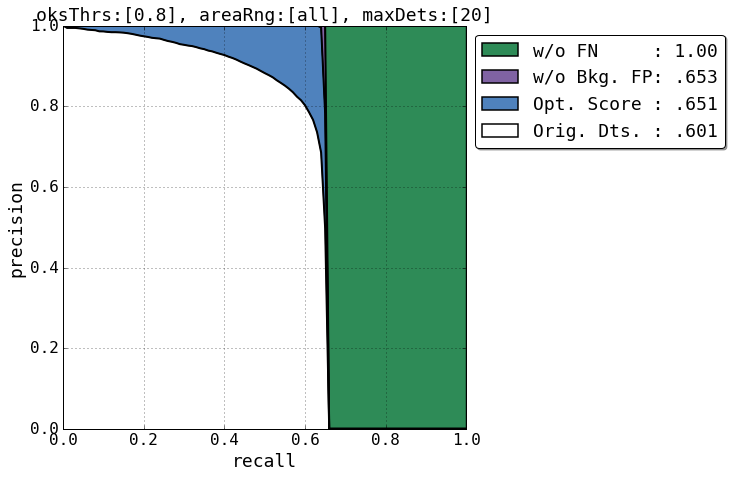

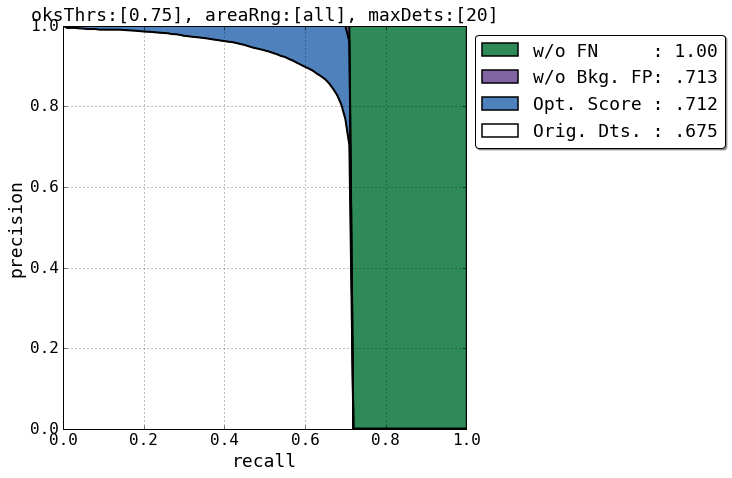

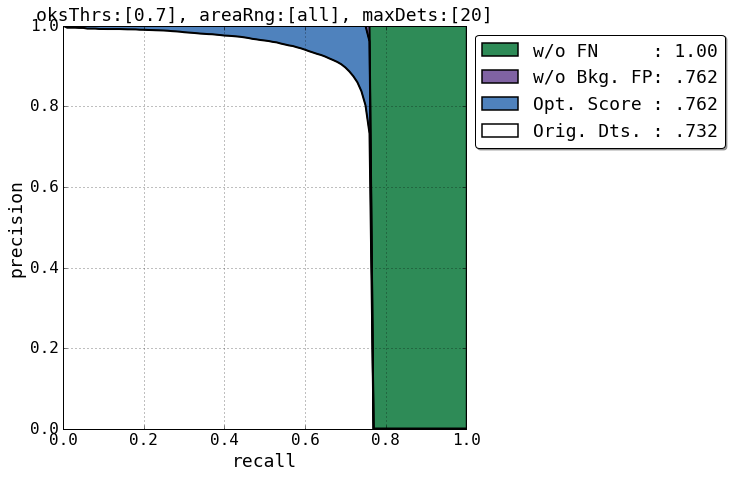

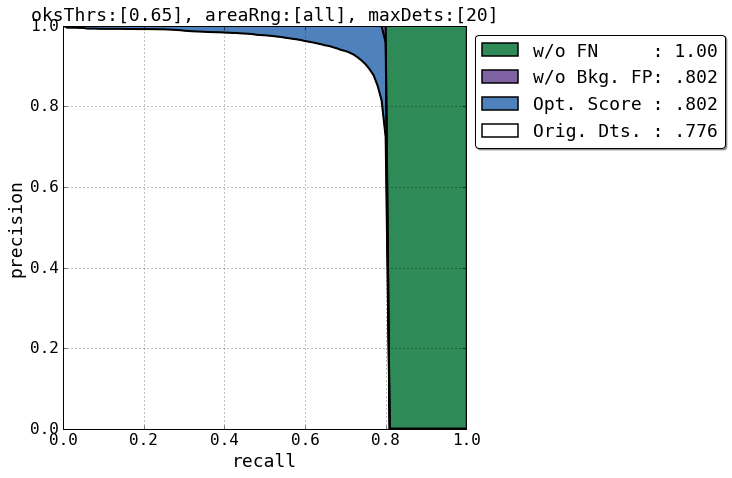

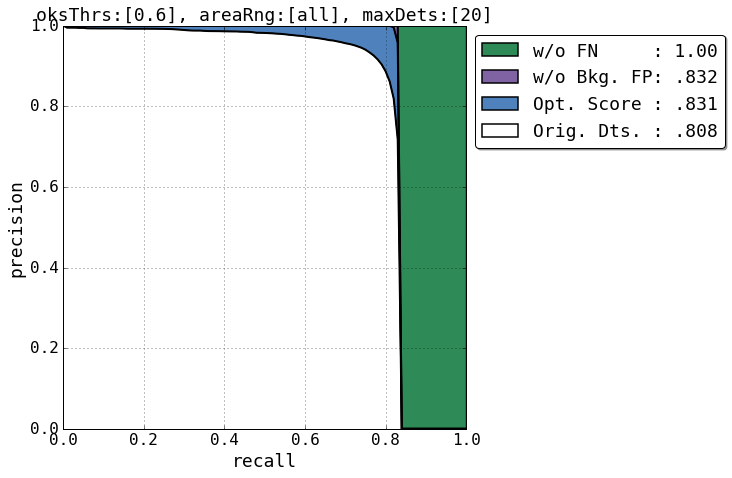

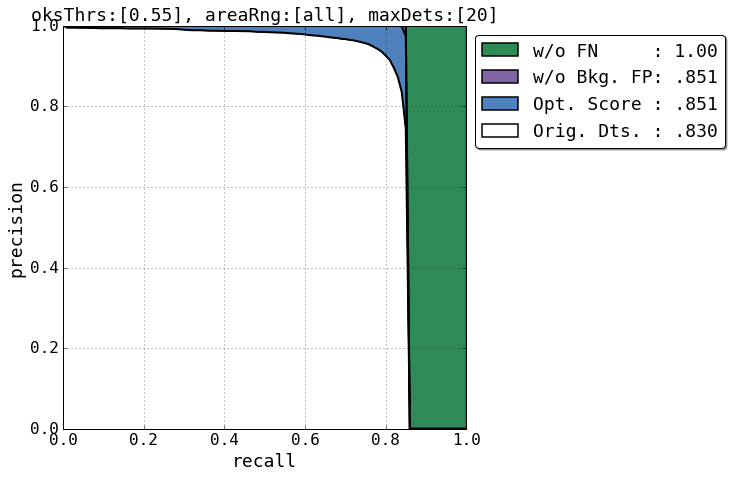

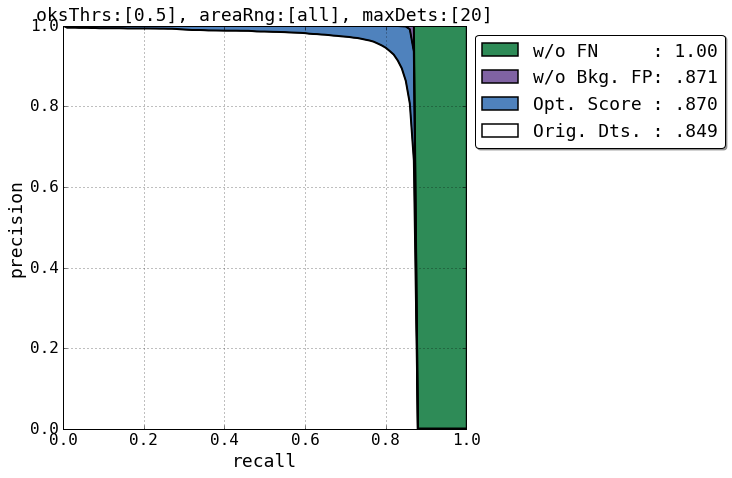

In [8]:
# use summarize() method to get the results after progressive correction of errors
# input arguments:
#  - makeplots : plots eval results (default: False)
#  - savedir   : path to savedir    (default: None)
#  - team_name : team name string   (default: None)

coco_analyze.summarize(makeplots=True)

In [9]:
for d in coco_analyze.corrected_dts['all'][:10]:
    print d
    print "===================================="

{'opt_score': 0.9541818070844883, 'area': 1993.6964190000006, u'keypoints': [300.711, 107.623, 1.0, 301.524, 105.997, 1.0, 299.084, 105.997, 1.0, 303.692, 105.997, 1.0, 297.187, 106.81, 1.0, 308.3, 113.044, 1.0, 294.205, 114.671, 1.0, 314.264, 120.905, 1.0, 288.784, 121.176, 1.0, 314.806, 127.41, 1.0, 290.41, 127.952, 1.0, 308.029, 132.289, 1.0, 298.542, 132.56, 1.0, 312.366, 146.656, 1.0, 288.242, 144.216, 1.0, 316.161, 160.48, 1.0, 279.568, 158.582, 1.0], u'image_id': 262144.0, u'score': 20.745, 'bbox': [279.56799999999998, 105.997, 36.593000000000018, 54.48299999999999], 'max_oks': 0.9541818070844883, u'category_id': 1.0, 'id': 1}
{'opt_score': 0.86326870197721528, 'area': 5405.4487300000019, u'keypoints': [607.747, 366.757, 1.0, 608.793, 357.342, 1.0, 625.007, 354.204, 1.0, 611.931, 354.204, 1.0, 628.145, 354.727, 1.0, 597.286, 363.096, 1.0, 635.467, 367.803, 1.0, 589.441, 388.201, 1.0, 638.605, 388.724, 1.0, 588.918, 398.139, 1.0, 636.513, 402.323, 1.0, 604.085, 407.553, 1.0, 627.

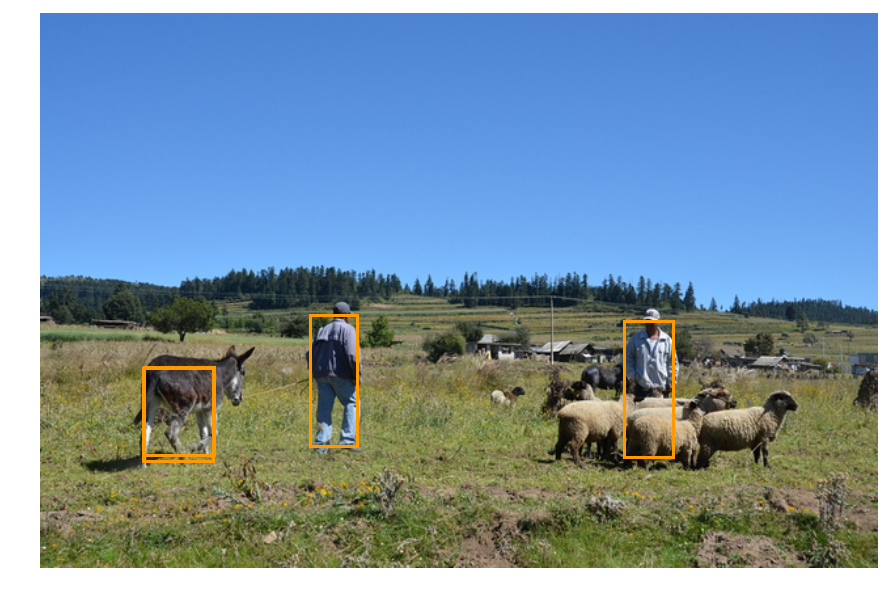

In [17]:
I = io.imread('http://mscoco.org/images/%d'%(65549))
plt.figure(figsize=(15,15)); plt.axis('off')
plt.imshow(I)
ax = plt.gca()
ax.set_autoscale_on(False)
for ann in coco_analyze.corrected_dts['all'][5:9]:
    bbox = ann['bbox']
    rect = plt.Rectangle((bbox[0],bbox[1]),bbox[2],bbox[3],fill=False,edgecolor=[1, .6, 0],linewidth=3)
    ax.add_patch(rect)

In [ ]:
print len(coco_analyze.cocoEval.ious.keys())
indx = 1
print coco_analyze.cocoEval.ious[coco_analyze.cocoEval.ious.keys()[indx]].shape
print coco_analyze.cocoEval.ious[coco_analyze.cocoEval.ious.keys()[indx]]

In [ ]:
dd = [d for d in coco_analyze.corrected_dts['medium'] if d['image_id']==466319]
print len(dd)

In [ ]:
for d in coco_analyze.corrected_dts['medium'][:10]:
    print d
    print

In [ ]:
weird = {}
for d in coco_analyze.corrected_dts['medium']:
    for oks in [.5,.55,.6,.65,.7,.75,.8,.85,.9,.95]:
        if d['id'] in coco_analyze.false_pos_dts['medium',oks] and d['opt_score']!=0:
            if oks in weird:
                weird[oks].append(d)
            else:
                weird[oks] = [d]
                
for l in weird:
    print l, len(weird[l])
    
print weird[.95][0]

In [ ]:
for k in coco_analyze.false_pos_dts: print k, len(coco_analyze.false_pos_dts[k]), type(coco_analyze.false_pos_dts[k])
print "============"
for d in list(coco_analyze.false_pos_dts['medium',.6])[:10]: print d

In [ ]:
print type(coco_analyze.corrected_dts), len(coco_analyze.corrected_dts)
print coco_analyze.corrected_dts.keys()

print type(coco_analyze.localization_matches), len(coco_analyze.localization_matches)
print coco_analyze.localization_matches.keys()

In [ ]:
## after analyze() has been called the following variables are available

# list of the corrected detections
corrected_dts = coco_analyze.corrected_dts

i = 17
# info on keypoint detection localization error
print 'good: %s'%corrected_dts[i]['good']
print 'miss: %s'%corrected_dts[i]['miss']
print 'swap: %s'%corrected_dts[i]['swap']
print 'inv.: %s'%corrected_dts[i]['inversion']
print 'jit.: %s\n'%corrected_dts[i]['jitter']

# corrected keypoint locations
print 'predicted keypoints:\n %s'%corrected_dts[i]['keypoints']
print 'corrected keypoints:\n %s\n'%corrected_dts[i]['opt_keypoints']

# optimal detection score
print 'original score: %s'%corrected_dts[i]['score']
print 'optimal score:  %s\n'%corrected_dts[i]['opt_score']

# dictionary with all detection and ground truth matches
dt_gt_matches = coco_analyze.matches
print "Dt-gt match:"
for k in dt_gt_matches['dts'][corrected_dts[i]['id']][0]:
    print k, dt_gt_matches['dts'][corrected_dts[i]['id']][0][k]

In [ ]:
## after summarize() has been called the following variables are available

# list of the missed ground-truth annotations
false_neg_gts = coco_analyze.false_neg_gts

In [ ]:
## list the performance summary 
for stat in coco_analyze.stats: print stat